In [3]:
import pprint
import config
import biothings
biothings.config_for_app(config)
import biothings.utils.mongo as mongo
col = mongo.get_src_db()["entrez_homologene"]
print(col)
docs = [d for d in col.find()]
print("%d GO documents" % len(docs))


Collection(Database(MongoClient(host=['su05:27017'], document_class=dict, tz_aware=False, connect=True), 'genedoc_src'), 'entrez_homologene')
269628 GO documents


# Structure analysis

In [14]:
import biothings.utils.inspect as inspect
mapt = inspect.inspect_docs(docs,mode="type")
pprint.pprint(mapt)

{'_id': {<class 'str'>: {}},
 'homologene': {'genes': {<class 'list'>: {<class 'list'>: {<class 'int'>: {}}}},
                'id': {<class 'int'>: {}}},
 'taxid': {<class 'int'>: {}}}


# ElasticSearch mapping generation

In [15]:
mapm = inspect.inspect_docs(docs,mode="mapping")
pprint.pprint(mapm) # same mode=type but some extra information about how values look like, relevant to ES


{'_id': {<class 'str'>: {}},
 'homologene': {'genes': {<class 'list'>: {<class 'list'>: {<class 'int'>: {}}}},
                'id': {<class 'int'>: {}}},
 'taxid': {<class 'int'>: {}}}


In [16]:
import biothings.utils.es as es
import importlib
importlib.reload(es)
mapping = es.generate_es_mapping(mapm)
pprint.pprint(mapping)

{'homologene': {'properties': {'genes': {'type': 'integer'},
                               'id': {'type': 'integer'}}},
 'taxid': {'type': 'integer'}}


# Structure statistics

In [10]:
import biothings.utils.inspect as inspect
import importlib
importlib.reload(inspect)
zedocs = docs#[:1000]
#mapt = inspect.inspect_docs(zedocs,mode="deepstats",clean=False)
##inspect.merge_scalar_list(mapt,"stats")
##print("BP contains scalar")
##pprint.pprint(mapt["go"]["BP"]["pubmed"])
#print("BP")
vals = mapt["homologene"]["genes"][list]["_stats"]["__vals"]
print(len(vals))
#bp = mapt["go"]["BP"]
#pm_aslist = 0
#pm_aslist_in_bp_asscalar = 0
#pm_aslist_in_bp_as_list = 0
#pm_asscalar = 0
#pm_asscalar_in_bp_asscalar = 0
#pm_asscalar_in_bp_aslist = 0
#for d in zedocs:
#    if type(d["go"].get("BP",{})) == list:
#        for bp in d["go"].get("BP"):
#            if type(bp.get("pubmed")) == list:
#                pm_aslist += 1
#                pm_aslist_in_bp_as_list += 1
#                break
#            else:
#                pm_asscalar += 1
#                pm_asscalar_in_bp_aslist += 1
#                break
#    elif d["go"].get("BP"):
#        bp = d["go"].get("BP")
#        if type(bp.get("pubmed")) == list:
#            pm_aslist_in_bp_asscalar += 1
#            pm_aslist += 1
#        elif bp.get("pubmed"):
#            pm_asscalar += 1
#            pm_asscalar_in_bp_asscalar += 1
#print("pm_aslist: %s" % pm_aslist)
#print("pm_asscalar: %s" % pm_asscalar)
#print("pm_aslist_in_bp_asscalar: %s" % pm_aslist_in_bp_asscalar)
#print("pm_aslist_in_bp_as_list (unknown for now): %s" % pm_aslist_in_bp_as_list)
#print("pm_asscalar_in_bp_asscalar: %s" % pm_asscalar_in_bp_asscalar)
#print("pm_asscalar_in_bp_aslist (unknown for now): %s" %pm_asscalar_in_bp_aslist)
#print("pm_total: %s" % (pm_aslist+pm_asscalar))

269628


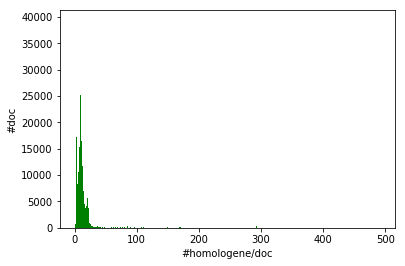

In [41]:
bins = {}
for c in vals:
    bins.setdefault(c,0)
    bins[c] += 1
#pprint.pprint(bins)
import numpy as np
import matplotlib.pyplot as plt
import mpld3
mpld3.enable_notebook()


plt.bar(list(bins.keys()), list(bins.values()), 1, color='g')
plt.xlabel("#homologene/doc")
plt.ylabel("#doc")
plt.bar?
plt.show()


In [115]:
_id_count = mapt["_id"][str]["_stats"]["_count"]
go_BP_evidence = mapt["go"]["BP"]["evidence"][str]["_stats"]["_count"]
go_BP_list_evience = mapt["go"]["BP"][list]["evidence"][str]["_stats"]["_count"]
print("count(_id): %s" % _id_count)
print("go.BP.evidence: %s" % go_BP_evidence)
print("go_BP_list_evidence: %s" % go_BP_list_evidence)
print("go_BP_list_vs_scalar: %.2f%% as list, %.2f%% as scalar" % \
      (go_BP_evidence/(go_BP_evidence+go_BP_list_evidence)*100,
       go_BP_list_evidence/(go_BP_evidence+go_BP_list_evidence)*100))


count(_id): 210029
go.BP.evidence: 77227
go_BP_list_evidence: 755275
go_BP_list_vs_scalar: 9.28% as list, 90.72% as scalar


# Fields relations

In [67]:
#import importlib
#import biothings.utils.inspect as inspect
#importlib.reload(inspect)
maptm = inspect.inspect_docs(docs,mode="stats",merge=True)
pprint.pprint(maptm)

TypeError: 'int' object is not subscriptable

In [123]:
inspect.merge_scalar_list(maptm,mode="stats")
pprint.pprint(mapt)

{'_id': {<class 'str'>: {'_stats': {'_count': 210029,
                                    '_max': 9,
                                    '_min': 1,
                                    '_sum': 1296264}}},
 'go': {'BP': {'evidence': {<class 'str'>: {'_stats': {'_count': 77227,
                                                       '_max': 3,
                                                       '_min': 2,
                                                       '_sum': 196504}}},
               'id': {<class 'str'>: {'_stats': {'_count': 77227,
                                                 '_max': 10,
                                                 '_min': 10,
                                                 '_sum': 772270}}},
               'pubmed': {<class 'list'>: {'_stats': {'_count': 278,
                                                      '_max': 4,
                                                      '_min': 2,
                                                      '_sum': 5

In [81]:
rootks = mapt["go"].keys()
for rootk in rootks:
    elems = maptm["go"][rootk][list]
    elemscnt = elems["_stats"]["_count"]
    print("go.%s: %s docs (%.2f%% of total docs)" % \
          (rootk,elemscnt,elemscnt/_id_count*100))
    kkeys = maptm["go"][rootk][list].keys()
    for kkey in kkeys:
        try:
            kcount = elems[kkey][str]["_stats"]["_count"]
        except KeyError as e: # well, it's not generic (but it could), we know how GO is...
            print(elems[kkey].keys())
            kcount = elems[kkey][int]["_stats"]["_count"]
        print("    go.%s.%s: %s elements (%.2f%% of elements in the list)" % \
              (rootk,kkey,kcount,kcount/_id_count*100))

go.CC: 109441 docs (52.11% of total docs)
    go.CC.id: 554761 elements (264.14% of elements in the list)
    go.CC.term: 554761 elements (264.14% of elements in the list)
dict_keys([<class 'int'>, <class 'list'>])
    go.CC.pubmed: 119933 elements (57.10% of elements in the list)
    go.CC.evidence: 554761 elements (264.14% of elements in the list)
    go.CC.qualifier: 7780 elements (3.70% of elements in the list)
dict_keys(['_count', '_min', '_sum', '_max'])


KeyError: <class 'int'>